In [192]:
%load_ext autoreload
%autoreload 2
import neptune as n
import copy
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
from image_registration import chi2_shift
from image_registration.fft_tools import shift
from astropy.io import fits

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
# first, average the flats
rerun_flats = False
if rerun_flats:
    medflats = n.process_flats()
else:
    medflats = n.retrieve_flats()

In [194]:
# first, average the sciences
sciences = n.divide_flats(n.get_sciences(), medflats)
sciences = n.renorm_and_crop_all(sciences, do_renorm=True)
# viewing the images and looking for Neptune shows us we should use
# 0 1 2 4 for H
# 0 1 2 4 for J (no 3 exists so you'll index into this as 0 1 2 3)
# 1 2 3 4 for Ks

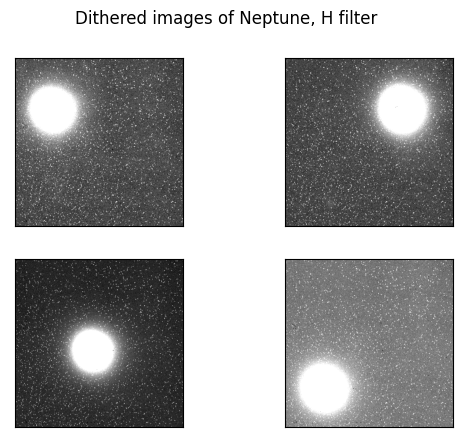

In [195]:
n.plot_all_images(sciences, "H")

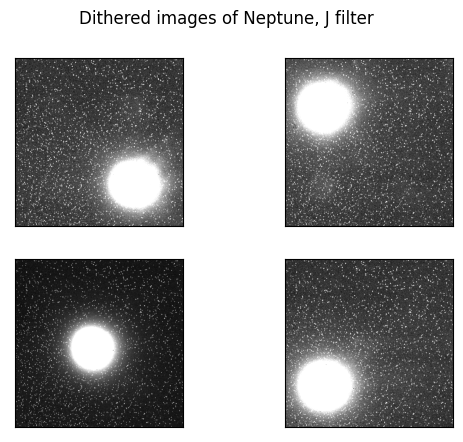

In [196]:
n.plot_all_images(sciences, "J")

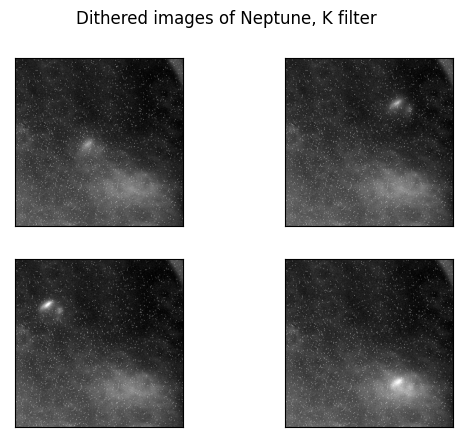

In [197]:
n.plot_all_images(sciences, "K")

In [215]:
np.nanmedian(sciences["H"], axis=0)

array([[0.89300566, 0.86843319, 0.88448483, ..., 0.89916754, 0.87740011,
        0.88130005],
       [0.8740224 , 0.85920794, 0.85805986, ..., 0.8739111 , 0.87204581,
        0.89519422],
       [0.88374001, 0.89497713, 0.88613694, ..., 0.87619774, 0.87534114,
        0.87505704],
       ...,
       [0.88299691, 0.88979274, 0.88722499, ..., 0.86884016, 0.87228585,
        0.88000332],
       [0.88415672, 0.89784704, 0.87976956, ..., 0.88742837, 0.87826423,
        0.87115433],
       [0.86904685, 0.89893358, 0.89111627, ..., 0.87143078, 0.87897165,
        0.86150403]])

In [216]:
science_medians = {}
for k in n.filternames:
    science_medians[k] = np.nanmedian(sciences[k], axis=0)
    for i in range(4):
        sciences[k][i] -= science_medians[k]

In [224]:
offsets = {k : np.zeros((4, 2)) for k in n.filternames}
offset_sciences = {k : [] for k in n.filternames}
for k in offsets:
    for i in range(4):
        offsets[k][i] = chi2_shift(sciences["H"][0], sciences[k][i])[:2]

# offsets["K"] = (offsets["J"] + offsets["H"]) / 2

for k in offsets:
    for i in range(4):
        dx, dy = offsets[k][i]
        offset_sciences[k].append(shift.shiftnd(sciences[k][i], (-dy, -dx)))

In [225]:
offsets

{'H': array([[ 1.95312500e-03, -1.95312500e-03],
        [ 2.40792969e+02,  8.71093750e-01],
        [ 1.25695312e+02,  1.25148438e+02],
        [ 4.57031250e+00,  2.38945312e+02]]),
 'J': array([[-2.44000000e+02,  2.28000000e+02],
        [ 2.14843750e-02, -5.27343750e-02],
        [ 1.22251953e+02,  1.14787109e+02],
        [ 3.36328125e+00,  2.35496094e+02]]),
 'K': array([[1.27373047e+02, 1.20525391e+02],
        [2.43000000e+02, 2.00000000e+00],
        [1.30859375e-01, 3.96484375e-01],
        [2.47000000e+02, 2.42000000e+02]])}

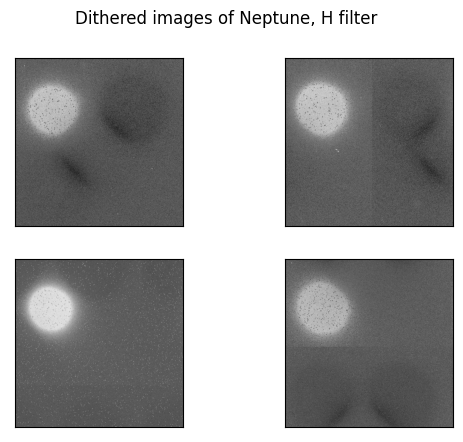

In [226]:
n.plot_all_images(offset_sciences, "H")

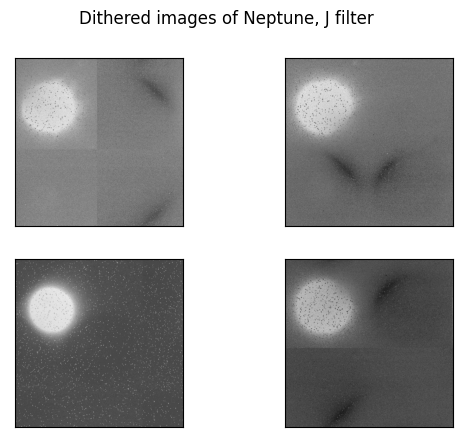

In [220]:
n.plot_all_images(offset_sciences, "J")

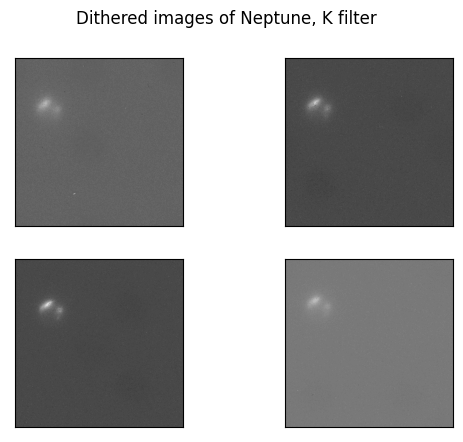

In [227]:
n.plot_all_images(offset_sciences, "K")

In [228]:
avg_img = lambda f, i: np.mean(offset_sciences[f][:i], axis=0)

In [229]:
for f in n.filternames:
    fits.writeto(f"neptune_{f}.fits", avg_img(f, 4), overwrite=True)

# fits.writeto(f"neptune_K.fits", avg_img("K", 1), overwrite=True)